# Underwater Image Enhancement - Shreyas Lal


> **Subtask 1: Variational Autoencoders (VAEs)**

**Import necessary libraries**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

**Set paths**

In [4]:
train_raw_path = '/kaggle/input/slal-task2-dataset/Train/Raw/'
train_ref_path = '/kaggle/input/slal-task2-dataset/Train/Reference/'

# Load Images

**Function to load and preprocess images**

In [7]:
def load_images(path, target_size=(480, 640)):
    images = []  # Initialize an empty list to store images
    for file in os.listdir(path):  # Loop through each file in the directory
        # Ensure the file is a valid image
        if file.endswith(('.png', '.jpg', '.jpeg')):  # Only load image files
            img = load_img(os.path.join(path, file), target_size=(480, 640)) # Load and resize image
            img = img_to_array(img) / 255.0  # Convert to array and normalize pixel values to [0, 1]
            images.append(img)  # Add the preprocessed image to the list
    return np.array(images)  # Convert list to numpy array and return

**Load training images and reference images**

In [8]:
train_images = load_images(train_raw_path)
reference_images = load_images(train_ref_path)

**Visualize a few loaded images**

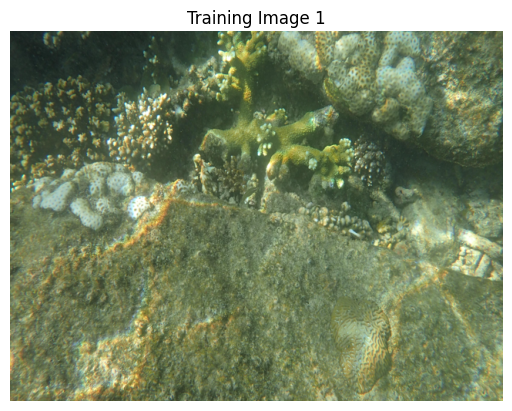

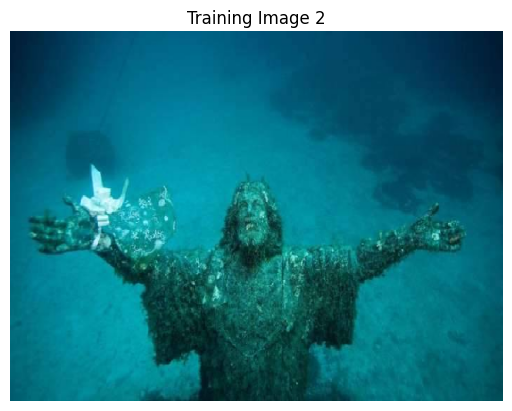

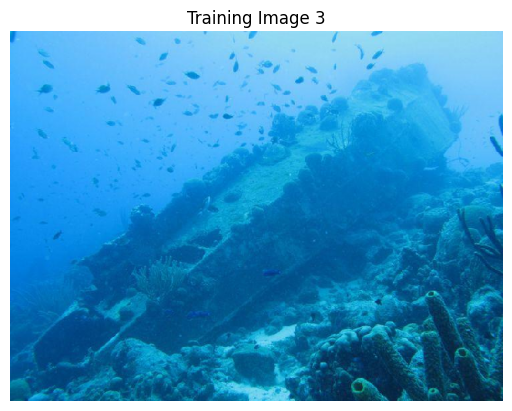

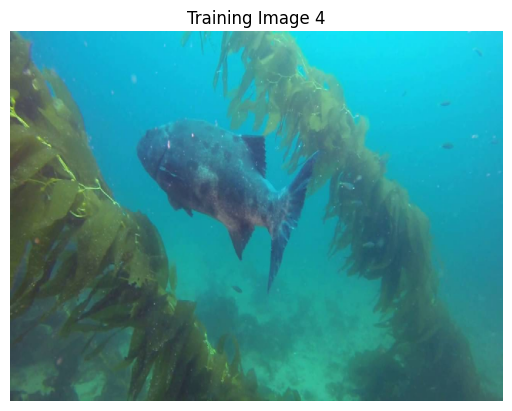

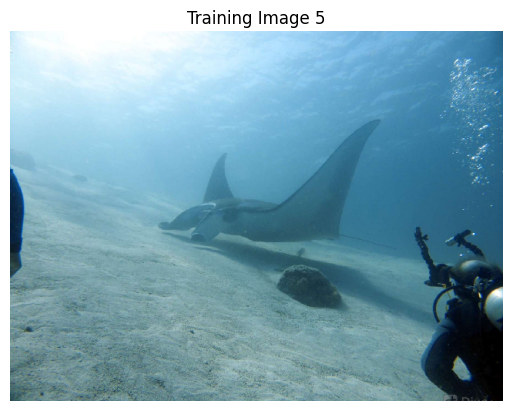

In [10]:
for i in range(min(5, len(train_images))):  
    plt.imshow(train_images[i])  
    plt.axis('off')  
    plt.title(f'Training Image {i+1}')
    plt.show()

In [12]:
# Define the VAE model
def build_vae():
    inputs = layers.Input(shape=(480, 640, 3))  # Input shape for images

    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)  # 1st convolutional layer
    x = layers.MaxPooling2D((2, 2))(x)  # Downsample the feature maps

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)  # 2nd convolutional layer
    x = layers.MaxPooling2D((2, 2))(x)  # Further downsampling

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)  # 3rd convolutional layer
    x = layers.MaxPooling2D((2, 2))(x)  # Further downsampling

    # Latent space
    x = layers.Flatten()(x)  # Flatten the output
    z_mean = layers.Dense(64)(x)  # Mean of the latent space
    z_log_var = layers.Dense(64)(x)  # Log variance of the latent space

    # Sampling layer
    z = layers.Lambda(sampling, output_shape=(64,))([z_mean, z_log_var])  # Sample from the latent space

    # Decoder
    x = layers.Dense(30 * 40 * 128, activation='relu')(z)  # Expand the latent representation
    x = layers.Reshape((30, 40, 128))(x)  # Reshape to a 3D tensor

    # Deconvolutional layers to upsample back to the original image size
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)  # 1st upsampling step
    x = layers.UpSampling2D((2, 2))(x)  # Upsample the feature maps

    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)  # 2nd upsampling step
    x = layers.UpSampling2D((2, 2))(x)  # Upsample again

    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)  # 3rd upsampling step
    x = layers.UpSampling2D((2, 2))(x)  # Upsample again

    # Final layer to output the reconstructed image
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)  # 3 channels for RGB

    vae = models.Model(inputs, outputs)  # Create the VAE model
    return vae

# Function for sampling from the latent space
def sampling(args):
    z_mean, z_log_var = args  # Get mean and log variance
    batch = tf.shape(z_mean)[0]  # Get the batch size
    dim = tf.shape(z_mean)[1]  # Get the dimension of the latent space
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Sample epsilon
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Return the sampled latent vector

# Load images
train_raw_path = '/kaggle/input/slal-task2-dataset/Train/Raw/'
train_images = load_images(train_raw_path)

# Compile and train the VAE
vae = build_vae()  # Build the VAE model
vae.compile(optimizer='adam', loss='binary_crossentropy')  # Compile model with Adam optimizer and binary crossentropy loss
vae.fit(train_images, train_images, epochs=50, batch_size=32)  # Train the VAE

# Function to generate enhanced images from the VAE
def generate_images(model, n=10):
    noise = np.random.normal(size=(n, 64))  # Generate noise in the latent space size (64)
    generated_images = model.predict(noise)  # Use the VAE model to generate images from the noise
    return generated_images

# Generate and visualize the enhanced images
generated_images = generate_images(vae, n=5)

# Evaluate and compare original and generated images
def evaluate_images(original, generated):
    mse_scores = []  # Store Mean Squared Error scores
    ssim_scores = []  # Store Structural Similarity Index scores
    for orig, gen in zip(original, generated):
        mse = mean_squared_error(orig.flatten(), gen.flatten())  # Calculate MSE
        ssim_value = ssim(orig, gen, multichannel=True)  # Calculate SSIM
        mse_scores.append(mse)  # Append MSE score
        ssim_scores.append(ssim_value)  # Append SSIM score
    return mse_scores, ssim_scores

# Evaluate the first few original images against generated images
mse_scores, ssim_scores = evaluate_images(train_images[:5], generated_images)

# Print evaluation results
print("Mean Squared Errors (MSE):", mse_scores)
print("Structural Similarity Indices (SSIM):", ssim_scores)

# Visualize original vs generated images
def visualize_comparison(original, generated):
    n = min(len(original), len(generated))
    plt.figure(figsize=(15, 6))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i])  # Original image
        plt.axis('off')  # Turn off axis labels
        plt.title("Original")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(generated[i])  # Generated image
        plt.axis('off')  # Turn off axis labels
        plt.title("Generated")
    plt.show()

# Compare the first few original and generated images
visualize_comparison(train_images[:5], generated_images)

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 480, 640, 3), output.shape=(None, 240, 320, 3)

# VAE Modelling

In [ ]:
# Sampling function for the reparameterization trick in VAEs
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build the VAE model
def build_vae():
    # Input shape adjusted for 640x480 RGB images
    inputs = layers.Input(shape=(480, 640, 3))
    
    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    
    # Latent space representation
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)  # Increased dense layer for complexity
    
    # Mean and log variance for the latent space
    z_mean = layers.Dense(32)(x)
    z_log_var = layers.Dense(32)(x)
    
    # Sample a point in latent space
    z = layers.Lambda(sampling)([z_mean, z_log_var])
    
    # Decoder
    x = layers.Dense(120 * 160 * 64, activation='relu')(z)  # Adjust based on downsampling
    x = layers.Reshape((120, 160, 64))(x)
    
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    
    # Final layer to output the reconstructed image with the same shape as the input
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    
    # Define the VAE model
    vae = models.Model(inputs, outputs)
    
    # Encoder and decoder models for optional use
    encoder = models.Model(inputs, z_mean)
    
    # Decoder input is latent space, then generate the image
    latent_inputs = layers.Input(shape=(32,))
    x = layers.Dense(120 * 160 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((120, 160, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoded_output = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    decoder = models.Model(latent_inputs, decoded_output)
    
    return vae, encoder, decoder

# Compile and train the VAE
vae, encoder, decoder = build_vae()
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Assuming 'train_images' is your dataset of underwater images
# Normalize train_images to the range [0, 1]
train_images = train_images / 255.0

vae.fit(train_images, train_images, epochs=50, batch_size=32)

# Function to generate images from random latent space vectors
def generate_images(decoder, n=10):
    noise = np.random.normal(size=(n, 32))  # Generate random vectors in latent space
    generated_images = decoder.predict(noise)  # Generate images using decoder
    return generated_images

# Generate and visualize the generated images
generated_images = generate_images(decoder)

for i in range(len(generated_images)):
    plt.imshow(generated_images[i])
    plt.axis('off')
    plt.show()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 985ms/step - loss: 0.6609
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 931ms/step - loss: 0.6310
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 968ms/step - loss: 0.6272
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 952ms/step - loss: 0.6244
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 959ms/step - loss: 0.6160
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 935ms/step - loss: 0.6054
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 935ms/step - loss: 0.5972
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 949ms/step - loss: 0.5949
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 932ms/step - loss: 0.5884
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 970ms/step - loss: 0.5885
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.5834
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 955ms/step - loss: 0.5843
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 925ms/step - loss: 0.5786
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 967ms/step - loss: 0.5787
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 923

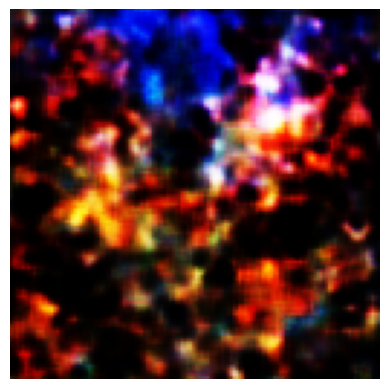

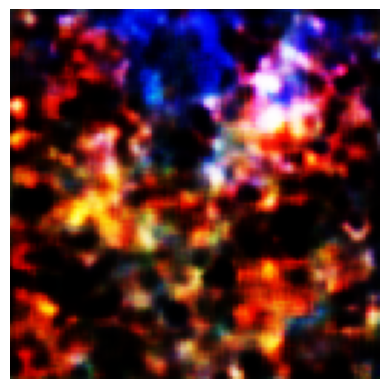

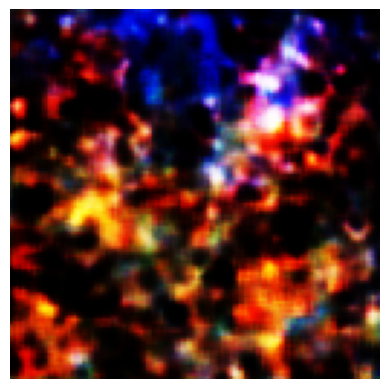

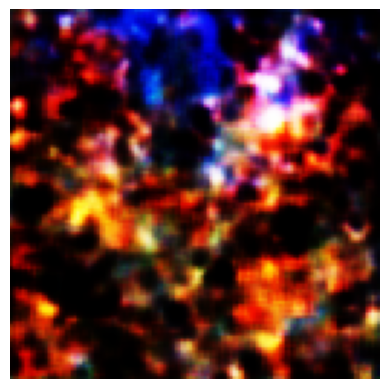

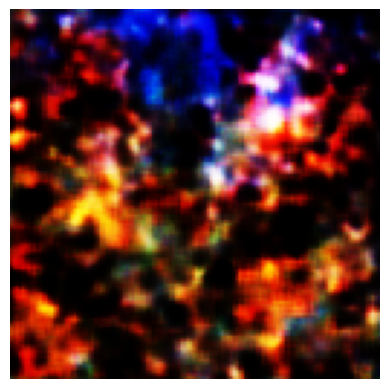

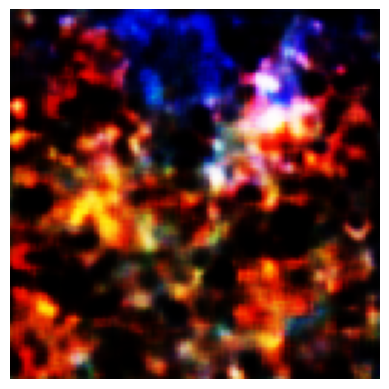

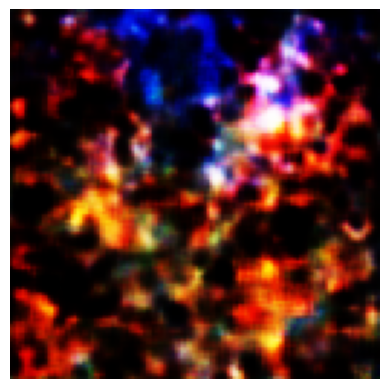

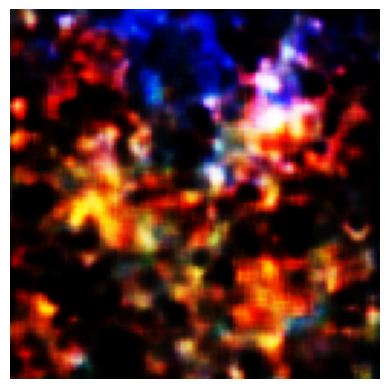

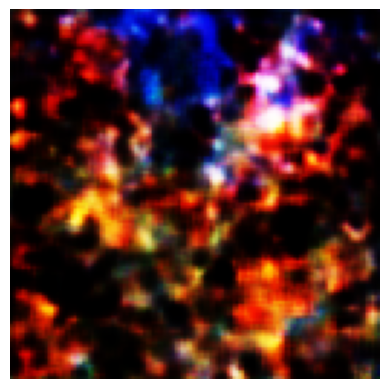

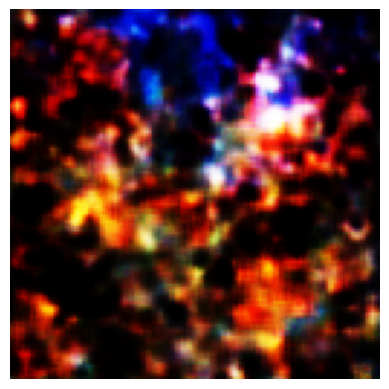

In [121]:
def build_vae():
    # Define the input shape for the encoder; here it's set for 128x128 RGB images
    inputs = layers.Input(shape=(128, 128, 3))
    
    # Encoder
    #Start with a convolutional layer followed by max pooling
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)# 32 filters, kernel size of 3x3
    x = layers.MaxPooling2D()(x) # Downsample the feature maps
    
    # Another convolutional layer to extract more features
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x) # 64 filters
    x = layers.MaxPooling2D()(x) # Further downsampling
    
    # Latent space
    #Flatten the output from the convolutional layers to create a vector representation
    latent_space = layers.Flatten()(x) # Convert to a 1D vector
    latent_space = layers.Dense(32)(latent_space) # Dense layer for latent representation

    # Decoder
    # Reconstruct the image from the latent space
    x = layers.Dense(64 * 32 * 32, activation='relu')(latent_space) # Dense layer to expand the latent representation
    x = layers.Reshape((32, 32, 64))(x) # Reshape into a 3D tensor (32x32 feature maps with 64 channels)
    
    # Deconvolutional layers to upsample back to the original image size
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x) # First upsampling step
    x = layers.UpSampling2D()(x) # Upsample the feature maps
    
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x) # Second upsampling step
    x = layers.UpSampling2D()(x) # Unsample again
    
    # Final layer to output the reconstructed image with same dimensions as input
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    # Create the VAE model combining inputs and outputs
    vae = models.Model(inputs, outputs)
    return vae

# Compile and train the VAE
vae = build_vae() # Build the VAE model
vae.compile(optimizer='adam', loss='binary_crossentropy') # Compile model with Adam optimizer and binary crossentropy loss
vae.fit(train_images, train_images, epochs=50, batch_size=32) # Train the VAE, using images as both input and output

# Function to generate enhanced images from the VAE
def generate_images(model, n=10):
    # Create an array of random noise with the same shape as the images
    noise = np.random.normal(size=(n, 128, 128, 3))  # Sample random noise
    generated_images = model.predict(noise) # Use the VAE model to generate images from the noise
    return generated_images

# Generate and visualize images
generated_images = generate_images(vae) # Call the function to generate a specified number of images
for i in range(len(generated_images)): # Loop through generated images
    plt.imshow(generated_images[i])
    plt.axis('off')
    plt.show()